In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, roc_auc_score, roc_curve, hamming_loss,precision_score,recall_score,f1_score

from confusion import make_confusion_matrix
import re

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 17

import warnings
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%matplotlib inline

In [2]:
data = pd.read_csv(f'../app/data/processed_data.csv')


In [3]:
data.text[0]

"job descriptiondata scientist, marketingsan diego, ca /analytics – data science /full-timeheadquartered in san diego, we serve as a leading provider of working capital ($5k - $1.5m) to the small and medium-sized businesses that fuel our country. since 2008, we have prided ourselves on our collaborative, innovative, and customer-focused approach. enjoying a period of unprecedented growth, driven by the combination of cutting-edge technology, human touch, and unwavering integrity, we are looking to add to our people-first culture, with highly motivated and results-oriented professionals, to push the limits of what's possible while creating value for all of our partners.we are seeking a mid-level to senior level statistician, quantitative modeling specialist, or data scientist to join our analytics team and build predictive models for marketing. if you have exceptional analytical, quantitative and problem-solving skills, demonstrated experience designing and implementing predictive model

In [4]:
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


In [5]:
def clean_text(data):
    sentences = data.split('.')
    clean_sentences = []
    for i in sentences:
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r'',i)
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|(0-9)]',r'',clean_sentence.strip(' '))
        if len(clean_sentence.strip()) > 1:
            clean_sentences.append(clean_sentence)
    done_sent = ''
    for i in clean_sentences:
        done_sent += (' '+i)
    return done_sent.strip()
    

data['cleaned'] = data.text.apply(clean_text)

In [6]:
data.cleaned[0]

'job descriptiondata scientist marketingsan diego ca analytics – data science full-timeheadquartered in san diego we serve as a leading provider of working capital k -  m to the small and medium-sized businesses that fuel our country since  we have prided ourselves on our collaborative innovative and customer-focused approach enjoying a period of unprecedented growth driven by the combination of cutting-edge technology human touch and unwavering integrity we are looking to add to our people-first culture with highly motivated and results-oriented professionals to push the limits of whats possible while creating value for all of our partners we are seeking a mid-level to senior level statistician quantitative modeling specialist or data scientist to join our analytics team and build predictive models for marketing if you have exceptional analytical quantitative and problem-solving skills demonstrated experience designing and implementing predictive models and analytics in marketing a pr

In [7]:
def clean_text(data):
    sentences = data.split('.')
    clean_sentences = []
    for i in sentences:
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r'',i)
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r'',clean_sentence)
        clean_sentence = " ".join(re.findall("[(a-zA-Z,&)]+", clean_sentence))
        clean_sentences.append(clean_sentence)
    clean_text = ''
    for i in clean_sentences:
        clean_text += (' '+i)
    return clean_text.strip(' ')

    

data['cleaned'] = data.text.apply(clean_text)



In [8]:
data.cleaned[3]

'li remote about eab at eab our mission is to make education smarter and our communities stronger we work with more than institutions to drive transformative change through data driven insights and best in class capabilities from kindergarten to college to career eab partners with leaders and practitioners to accelerate progress and drive results across five major areas enrollment student success institutional strategy data & analytics and diversity equity and inclusion de&i we work with each partner differently tailoring our portfolio of research technology and marketing and enrollment solutions to meet the unique needs of every leadership team as well as the students and employees they serve at eab we serve not only our partner institutions but each other thats why we are always working to make sure our employees love their jobs and are invested in their communities see how weve been recognized for this dedication to our employees by checking out our recent awards for more informatio

### 4.1 Target
Before I can begin splitting the data I need to set the target for my methodology of training four seperate logistic regression models. I'm doing this because I'd like my classifications to be as accurate as possible, and also, by building my NLP strategy around a particular label, i.e. finding common words for that label as opposed to being generalized through the entire corpus\

I'm going to one-hot-encode the target feature so I can select each of the next columns as my y - one for each model.

In [9]:
data = data[['company','job_title','state','city','rating','cleaned','target']]

In [10]:
ohe = OneHotEncoder(sparse=False, dtype='int')
targets = ohe.fit_transform(pd.DataFrame(data.target))


In [11]:
targets = pd.DataFrame(targets,columns=['Q1','Q2','Q3','Q4','unk'])


In [12]:
data = data.join(targets)
data.head()

,company,job_title,state,city,rating,cleaned,target,Q1,Q2,Q3,Q4,unk
0,online technical services,data scientist - marketing,remote,remote,3.7,job descriptiondata scientist marketingsan die...,4.0,0,0,0,1,0
1,west cap,"data scientist, botguard",ny,remote in new york,3.5,human was founded in in a brooklyn sci fi book...,2.0,0,1,0,0,0
2,techtrueup,mcs data scientist,remote,remote,3.8,description data scientist fully remote develo...,3.0,0,0,1,0,0
3,eab,associate data scientist,dc,remote in washington,3.7,li remote about eab at eab our mission is to m...,1.0,1,0,0,0,0
4,redfin,senior data analyst - tour support (remote eli...,remote,remote,3.4,this position is a remote eligible position yo...,2.0,0,1,0,0,0


In [13]:
data.drop(['target','unk'], axis=1,inplace=True)

In [14]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


data['comment_text'] = data['cleaned'].apply(stemming)

In [15]:
data.comment_text[0]

'job descriptiondata scientist marketingsan diego ca analyt data scienc full timeheadquart in san diego we serv as a lead provid of work capit k m to the small and medium size busi that fuel our countri sinc we have pride ourselv on our collabor innov and custom focus approach enjoy a period of unpreced growth driven by the combin of cut edg technolog human touch and unwav integr we are look to add to our peopl first cultur with high motiv and result orient profession to push the limit of what possibl while creat valu for all of our partner we are seek a mid level to senior level statistician quantit model specialist or data scientist to join our analyt team and build predict model for market if you have except analyt quantit and problem solv skill demonstr experi design and implement predict model and analyt in market a proven track record of bring thought leadership to problem and the desir to make a rapid impact on the success of the busi this is an opportun for you the ideal candid

In [16]:
from nltk.stem import WordNetLemmatizer



lemmatizer = WordNetLemmatizer()
def stemming(sentence):
    LemSentence = ""
    for word in sentence.split():
        stem = lemmatizer.lemmatize(word)
        LemSentence += stem
        LemSentence += " "
    LemSentence = LemSentence.strip()
    return LemSentence


data['comment_text_lem'] = data['cleaned'].apply(stemming)
data.comment_text_lem[0]

'job descriptiondata scientist marketingsan diego ca analytics data science full timeheadquartered in san diego we serve a a leading provider of working capital k m to the small and medium sized business that fuel our country since we have prided ourselves on our collaborative innovative and customer focused approach enjoying a period of unprecedented growth driven by the combination of cutting edge technology human touch and unwavering integrity we are looking to add to our people first culture with highly motivated and result oriented professional to push the limit of whats possible while creating value for all of our partner we are seeking a mid level to senior level statistician quantitative modeling specialist or data scientist to join our analytics team and build predictive model for marketing if you have exceptional analytical quantitative and problem solving skill demonstrated experience designing and implementing predictive model and analytics in marketing a proven track recor

In [17]:
data.drop(['cleaned','comment_text'], axis=1,inplace=True)

In [18]:
data

,company,job_title,state,city,rating,Q1,Q2,Q3,Q4,comment_text_lem
0,online technical services,data scientist - marketing,remote,remote,3.7,0,0,0,1,job descriptiondata scientist marketingsan die...
1,west cap,"data scientist, botguard",ny,remote in new york,3.5,0,1,0,0,human wa founded in in a brooklyn sci fi books...
2,techtrueup,mcs data scientist,remote,remote,3.8,0,0,1,0,description data scientist fully remote develo...
3,eab,associate data scientist,dc,remote in washington,3.7,1,0,0,0,li remote about eab at eab our mission is to m...
4,redfin,senior data analyst - tour support (remote eli...,remote,remote,3.4,0,1,0,0,this position is a remote eligible position yo...
...,...,...,...,...,...,...,...,...,...,...
1025,etsy,senior applied scientist ii-knowledge base,wa,remote in seattle,4.3,0,0,0,0,company description etsy is the global marketp...
1026,nike,"senior data scientist (open to remote work, ex...",or,remote in beaverton,4.1,0,0,0,0,become a part of the nike inc teamnike inc doe...
1027,windstream communications,senior data scientist,remote,remote,3.2,0,0,0,0,we are looking for a data scientist to help u ...
1028,nike,"senior data scientist (open to remote work, ex...",or,remote in beaverton,4.1,0,0,0,0,become a part of the nike inc teamnike inc doe...


I need to make one model for each target. Before doing so, I'll need to use gridsearch to find the best hyperperamters.
Looping through each target, I set y to that specific single-column binary '(for target in targets target == 0 or 1)'
Then do a test train split before setting up the pipeline. The grid being use in this case is the selection of hyperperamters I want to check.


In [19]:
def grid_search_pipe():
    targets = ['Q1','Q2','Q3','Q4']
    X = data.drop(targets, axis=1)

    le_cols = ['company', 'job_title', 'state', 'city']
    scal_cols = ['rating']

    evaluations = {}

    
    for i in targets:
    # test/train split
        y = data[i]
        x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)


        preprocessor = ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(ngram_range=(1,3), analyzer = 'word',max_features=1000,stop_words='english',decode_error='ignore'), 'comment_text_lem'),
                ('category', OneHotEncoder(handle_unknown ='ignore'), le_cols),
                ('scaler', StandardScaler(), scal_cols)
                
                ],remainder='drop')
        #   populating parameter grid to search
        grid = [
            {
            'classifier' : [LogisticRegression()],
            'classifier__penalty' : ['l1', 'l2'],
            #'classifier__C' : np.logspace(-4, 4, 20),
            'classifier__solver' : ['liblinear']}
            ]

        pipe = Pipeline(
            steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(grid)),
            ],
            )


        
        grid_search = GridSearchCV(pipe, param_grid=grid, verbose=2, return_train_score=True)
        grid_search.fit(x_train,y_train)

        print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
        print(grid_search.best_params_)


        if i not in evaluations.keys():
            evaluations[i] = {
                'grid_search':grid_search,
                'x_train':x_train,
                'y_train':y_train,
                'x_test':x_test,
                'y_test':y_test
                
            }


    return evaluations


evaluations = grid_search_pipe()

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END classifier=LogisticRegression(), classifier__penalty=l1, classifier__solver=liblinear; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__penalty=l1, classifier__solver=liblinear; total time=   0.8s
[CV] END classifier=LogisticRegression(), classifier__penalty=l1, classifier__solver=liblinear; total time=   0.8s
[CV] END classifier=LogisticRegression(), classifier__penalty=l1, classifier__solver=liblinear; total time=   0.8s
[CV] END classifier=LogisticRegression(), classifier__penalty=l1, classifier__solver=liblinear; total time=   0.8s
[CV] END classifier=LogisticRegression(), classifier__penalty=l2, classifier__solver=liblinear; total time=   0.8s
[CV] END classifier=LogisticRegression(), classifier__penalty=l2, classifier__solver=liblinear; total time=   0.8s
[CV] END classifier=LogisticRegression(), classifier__penalty=l2, classifier__solver=liblinear; total time=   0.8s
[CV] END classifier=

In [20]:
def make_model(evaluations):


    targets = ['Q1','Q2','Q3','Q4']
    X = data.drop(targets, axis=1)

    test_results = {}

    for i in targets:
        evaluation = evaluations[i]['grid_search']
        params = evaluation.best_params_


        y = data[i]
        x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)



        le_cols = ['company', 'job_title', 'state', 'city']
        scal_cols = ['rating']

        preprocessor = ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(ngram_range=(1,3), analyzer = 'word',max_features=1000,stop_words='english',decode_error='ignore'), 'comment_text_lem'),
                ('category', OneHotEncoder(handle_unknown ='ignore'), le_cols),
                ('scaler', MinMaxScaler(), scal_cols)
                
                ],remainder='drop')


        pipe = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('classifier', params['classifier']),
            ],
        )


        pipe.fit(x_train,y_train)

        predictions = pipe.predict(x_test)
        score = pipe.score(x_train, y_train)


        ### check
        check = pd.DataFrame(preprocessor.fit_transform(x_train,y_train).toarray())


        if i not in test_results.keys():
            test_results[i] = pipe, x_train, y_train, x_test, y_test, predictions, score
                
    return test_results, check
        
test_results, check = make_model(evaluations)


In [21]:
def combinator(test_results):
    targets = ['Q1','Q2','Q3','Q4']

    resultsDB = {}
    lst = []

    
    for label in targets:
        data_dict = {}
        pipe = test_results[label][0]
        x_test = test_results[label][3]
        y_test = test_results[label][4]
        y_prob = pipe.predict_proba(x_test)
        predict_y = pipe.predict(x_test)
        data_dict = {
            f'{label}_y_test':y_test, 
             f'{label}_pred y': predict_y.tolist(),
             f'{label}_probabilities': y_prob.tolist()
             }
        zulu = x_test.join(pd.DataFrame(data_dict))
        if label not in resultsDB.keys():
            resultsDB[label] = zulu
        else:
            continue


        out = pd.DataFrame(data_dict)
        lst.append(out)

    results_table = x_test
    for i, label in zip(lst, targets):
        results_table = results_table.join(i, lsuffix=label)
    #results_table = results_table.join(lst[1], lsuffix='__')
    #for label, results in zip(targets,lst):
    #    results_table = results_table.join(results, lsuffix=label)
    return resultsDB, results_table, lst
   

data_dict, results_table, lst = combinator(test_results)

In [22]:
len(test_results['Q1'])

7

In [23]:
pipe = test_results['Q1'][0]
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(decode_error='ignore',
                                                                  max_features=1000,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words='english'),
                                                  'comment_text_lem'),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['company', 'job_title',
                                                   'state', 'city']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['rating'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [24]:
x_train = test_results['Q1'][1]
x_train

,company,job_title,state,city,rating,comment_text_lem
995,spotify,"data scientist, advertising economics",ny,remote in new york,4.3,data research & insightsdata scienceat spotify...
507,s&p global,data scientist,tn,remote in nashville,3.9,segment market intelligence the role data scie...
334,cybercoders,remote senior data analyst,ca,remote in san francisco,3.7,remote senior data analyst if you are a senior...
848,galaxe.solutions,data analyst,wi,remote in milwaukee,2.5,what you will dowell acquainted with the dba r...
294,galaxe.solutions,data analyst,wi,remote in milwaukee,2.5,what you will dowell acquainted with the dba r...
...,...,...,...,...,...,...
87,online technical services,data scientist - marketing,remote,remote,3.7,job descriptiondata scientist marketingsan die...
330,cybercoders,principal data scientist,wa,remote in seattle,3.7,principal data scientist if you are a principa...
466,sparkcognition,machine learning engineer,tx,remote in austin,4.4,voted best place to work in austin best paying...
121,amadeus,principal data scientist - network planning fo...,remote,remote,3.9,summary of the rolewhere to fly when to fly wh...


In [25]:
y_train = test_results['Q1'][2]
y_train

995    0
507    0
334    0
848    0
294    1
      ..
87     0
330    0
466    0
121    0
860    0
Name: Q1, Length: 824, dtype: int64

In [26]:
x_test = test_results['Q1'][3]
x_test

,company,job_title,state,city,rating,comment_text_lem
31,amadeus,principal data scientist - network planning fo...,remote,remote,3.9,summary of the rolewhere to fly when to fly wh...
109,redfin,senior data analyst - tour support (remote eli...,remote,remote,3.4,this position is a remote eligible position yo...
136,techtrueup,mcs data scientist,remote,remote,3.8,description data scientist fully remote develo...
88,calculated hire,data scientist,remote,remote,3.9,business analytics analyst industry bankingfin...
918,angi,senior data scientist,co,remote in denver,3.3,angi is transforming the home service industry...
...,...,...,...,...,...,...
482,s&p global,data scientist,tn,remote in nashville,3.9,segment market intelligence the role data scie...
545,kane partners llc,machine learning engineer,pa,remote in philadelphia,5.0,remote position descriptionas a machine learni...
110,sparkcognition,data scientist ii,tx,remote in austin,4.4,voted best place to work in austin best paying...
514,cybercoders,remote senior data analyst,ca,remote in san francisco,3.7,remote senior data analyst if you are a senior...


In [27]:
y_test = test_results['Q1'][4]
y_test

31     0
109    0
136    0
88     1
918    0
      ..
482    0
545    0
110    0
514    0
602    0
Name: Q1, Length: 206, dtype: int64

In [28]:
predictions =  test_results['Q1'][5]
predictions

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0])

In [29]:
score =  test_results['Q1'][6]
score

0.9757281553398058

In [30]:
score = pipe.score(x_train, y_train)
score

0.9757281553398058

In [31]:

predictions = pipe.predict(x_test)
predictions

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0])

In [32]:
print("Accuracy :",accuracy_score(y_test, predictions))

Accuracy : 0.9757281553398058


In [33]:

print("Hamming loss ",hamming_loss(y_test,predictions))

Hamming loss  0.024271844660194174


In [34]:

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

In [35]:
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Micro-average quality numbers
Precision: 0.9757, Recall: 0.9757, F1-measure: 0.9757


In [36]:
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

In [37]:
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Macro-average quality numbers
Precision: 0.9430, Recall: 0.9737, F1-measure: 0.9575


In [38]:
print("\nClassification Report")
print (classification_report(y_test, predictions))


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       172
           1       0.89      0.97      0.93        34

    accuracy                           0.98       206
   macro avg       0.94      0.97      0.96       206
weighted avg       0.98      0.98      0.98       206



In [39]:

pipe.score(x_train, y_train)

0.9757281553398058

In [40]:
cf1 = confusion_matrix(y_test, predictions)

In [41]:
Q = ['Q1']
te_confusions = [cf1]
y_t = [y_test]
te_probs = [pipe.predict_proba(x_test)]
y_pred = [predictions]
y_test_preds = predictions
y_prob = [pipe.predict_proba(x_test)]

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       172
           1       0.89      0.97      0.93        34

    accuracy                           0.98       206
   macro avg       0.94      0.97      0.96       206
weighted avg       0.98      0.98      0.98       206



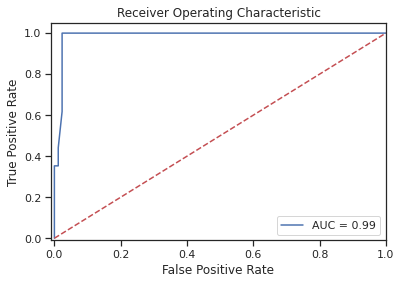

In [43]:
import sklearn.metrics as metrics# calculate the fpr and tpr for all thresholds of the classification
probs = pipe.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-.01, 1.])
plt.ylim([-.01, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

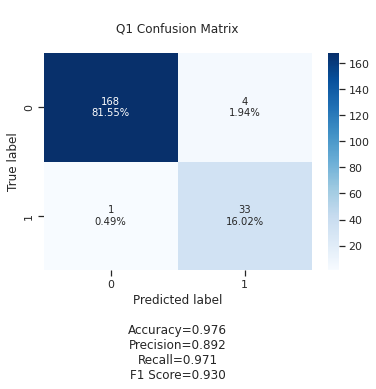

In [44]:
for title, cf, y_t, y_pred, y_prob in zip(Q, te_confusions, y_test, y_test_preds, te_probs):
    make_confusion_matrix(cf, title='\n'+title+' Confusion Matrix\n')


In [45]:

X_tfidf = tfidf.fit_transform(_test).toarray()
vocab = q1_vectorizer.vocabulary_
reverse_vocab = {v:k for k,v in vocab.items()}

feature_names = tfidf.get_feature_names()
df_tfidf = pd.DataFrame(X_tfidf, columns = feature_names)

idx = X_tfidf.argsort(axis=1)

tfidf_max10 = idx[:,-10:]

df_tfidf['top10'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_max10 ]

df_tfidf['top10']


NameError: name 'tfidf' is not defined

In [46]:
results_table

,company,job_title,state,city,rating,comment_text_lem,Q1_y_test,Q1_pred y,Q1_probabilities,Q2_y_test,Q2_pred y,Q2_probabilities,Q3_y_test,Q3_pred y,Q3_probabilities,Q4_y_test,Q4_pred y,Q4_probabilities
31,amadeus,principal data scientist - network planning fo...,remote,remote,3.9,summary of the rolewhere to fly when to fly wh...,0,0,"[0.9402496237514776, 0.059750376248522405]",0,0,"[0.9740768358495931, 0.025923164150406817]",0,0,"[0.9809993762418174, 0.01900062375818253]",1,1,"[0.16646224970879653, 0.8335377502912035]"
109,redfin,senior data analyst - tour support (remote eli...,remote,remote,3.4,this position is a remote eligible position yo...,0,0,"[0.9591205544923498, 0.04087944550765021]",1,1,"[0.10980806772576313, 0.8901919322742369]",0,0,"[0.9809993762418174, 0.01900062375818253]",0,0,"[0.9848684293588506, 0.015131570641149427]"
136,techtrueup,mcs data scientist,remote,remote,3.8,description data scientist fully remote develo...,0,0,"[0.9643474270959249, 0.03565257290407513]",0,0,"[0.9839499201584234, 0.016050079841576536]",1,1,"[0.055619297934215606, 0.9443807020657844]",0,0,"[0.9848684293588506, 0.015131570641149427]"
88,calculated hire,data scientist,remote,remote,3.9,business analytics analyst industry bankingfin...,1,1,"[0.13274469932164368, 0.8672553006783563]",0,0,"[0.9739551797830662, 0.026044820216933797]",0,0,"[0.9910827144805824, 0.008917285519417586]",0,0,"[0.9848684293588506, 0.015131570641149427]"
918,angi,senior data scientist,co,remote in denver,3.3,angi is transforming the home service industry...,0,0,"[0.9812317559448978, 0.018768244055102273]",0,0,"[0.9837307138880119, 0.016269286111988034]",0,0,"[0.9813697077215922, 0.018630292278407855]",0,0,"[0.9856857462469125, 0.014314253753087508]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,s&p global,data scientist,tn,remote in nashville,3.9,segment market intelligence the role data scie...,0,0,"[0.9828641079389114, 0.01713589206108858]",1,1,"[0.0515502388873863, 0.9484497611126137]",0,0,"[0.9912582680317642, 0.008741731968235794]",0,0,"[0.9856857462469125, 0.014314253753087508]"
545,kane partners llc,machine learning engineer,pa,remote in philadelphia,5.0,remote position descriptionas a machine learni...,0,0,"[0.9839394919042179, 0.01606050809578207]",1,1,"[0.19553043291486782, 0.8044695670851322]",0,0,"[0.9813697077215922, 0.018630292278407855]",0,0,"[0.9856857462469125, 0.014314253753087508]"
110,sparkcognition,data scientist ii,tx,remote in austin,4.4,voted best place to work in austin best paying...,0,0,"[0.9932369935739201, 0.00676300642607981]",0,0,"[0.9419825331264206, 0.05801746687357948]",1,1,"[0.07150888747140716, 0.9284911125285928]",0,0,"[0.9856857462469125, 0.014314253753087508]"
514,cybercoders,remote senior data analyst,ca,remote in san francisco,3.7,remote senior data analyst if you are a senior...,0,0,"[0.9758642306928212, 0.024135769307178784]",0,0,"[0.9917045949723181, 0.008295405027681897]",0,0,"[0.9813697077215922, 0.018630292278407855]",1,1,"[0.03222423758980053, 0.9677757624101995]"
